This is a simulation of the rerouting algorithm. We will be using the PUJ route T307 (Boni - Pinatubo → Stop n' Shop).

In [1]:
!pip3 install -q osmnx contextily overpass overpy osmapi


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import pandas as pd
import osmnx as ox
import random
import json
import geopandas as gpd
import numpy as np
import random
import itertools

import overpass
from shapely.geometry import Polygon, LineString, Point
import overpy
from osmapi import OsmApi

## Prepare Data

### Creating Bounding Box

In [3]:
BOUNDING_BOX = (14.80719172, 14.31891701, 121.1424698, 120.9012584) # bounding box as (north, south, east, west)
graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)

/var/folders/50/xdm9z86x52j383crwg6sv7sc0000gn/T/ipykernel_13714/1866789885.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)


### Plot Area

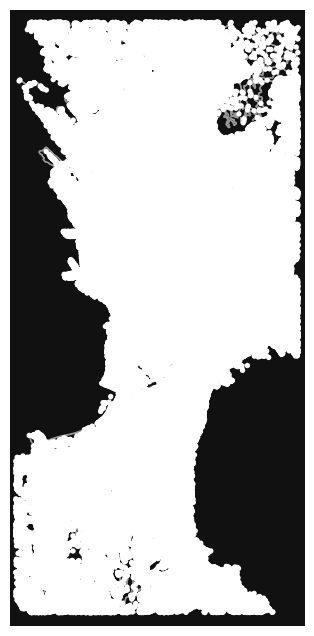

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(graph_of_area)

In [5]:
gdf_edges = ox.graph_to_gdfs(graph_of_area, nodes=False)

In [6]:
gdf_edges.head()

osmid                   name  \
u        v          key                                                  
12067302 1686647100 0                   2667105     E. Manaloto Street   
         2950125788 0                 224039651  F. B. Harrison Street   
         6510185271 0                 224039651  F. B. Harrison Street   
12067308 8562405196 0                 224039655  F. B. Harrison Street   
         1723298722 0    [644875507, 840378998]                   EDSA   

                             highway  oneway reversed   length   lanes  \
u        v          key                                                  
12067302 1686647100 0    residential   False     True  129.271     NaN   
         2950125788 0      secondary   False    False   34.788       2   
         6510185271 0      secondary   False     True   64.711       2   
12067308 8562405196 0      secondary   False     True    6.003       2   
         1723298722 0          trunk    True    False  175.734  [4, 5]   

                        maxspeed width  \
u        v          key                  
12067302 1686647100 0        NaN   NaN   
         2950125788 0         40     8   
         6510185271 0         40     8   
12067308 8562405196 0         40     8   
         1723298722 0         60   NaN   

                                                                  geometry  \
u        v          key                                                      
12067302 1686647100 0    LINESTRING (120.99497 14.54151, 120.99380 14.5...   
         2950125788 0    LINESTRING (120.99497 14.54151, 120.99504 14.5...   
         6510185271 0    LINESTRING (120.99497 14.54151, 120.99486 14.5...   
12067308 8562405196 0    LINESTRING (120.99573 14.53787, 120.99572 14.5...   
         1723298722 0    LINESTRING (120.99573 14.53787, 120.99516 14.5...   

                         ref access junction tunnel bridge service area  
u        v          key                                                  
12067302 1686647100 0    NaN    NaN      NaN    NaN    NaN     NaN  NaN  
         2950125788 0    NaN    NaN      NaN    NaN    NaN     NaN  NaN  
         6510185271 0    NaN    NaN      NaN    NaN    NaN     NaN  NaN  
12067308 8562405196 0    NaN    NaN      NaN    NaN    NaN     NaN  NaN  
         1723298722 0      1    NaN      NaN    NaN    NaN     NaN  NaN

In [7]:
gdf_edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
gdf_edges_web_mercator = gdf_edges.to_crs(epsg=3857)

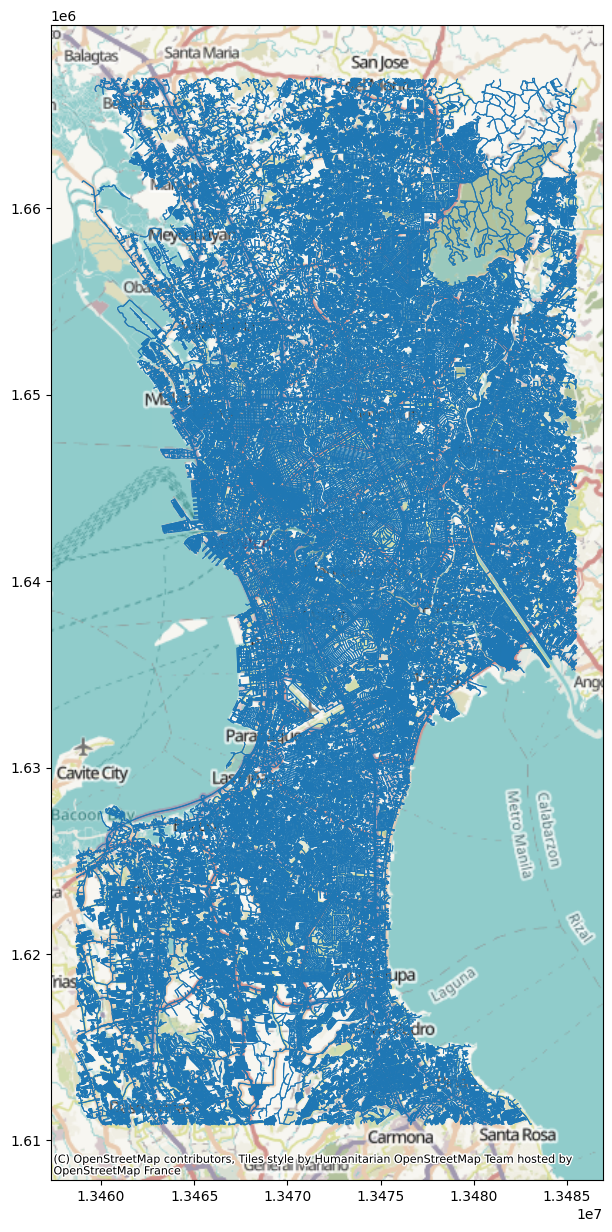

In [9]:
_, ax = plt.subplots(1,1, figsize=(15,15))
gdf_edges_web_mercator.plot(linewidth=.75, ax=ax)
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.Positron)

### Using overpy

In [32]:
def get_nodes():
    for result in results:
        for way in result.get_ways():
            for node in way.get_nodes(resolve_missing=True):
                yield node

def get_ways():
    for way in result.get_ways():
        yield LineString(Point(node.lon, node.lat) for node in way.get_nodes(resolve_missing=True))

In [11]:
def _get_way_ids(relation_id):
    query = f"""
    relation({relation_id});
    out body;
    """
    
    # Fetch the relation data
    result = api.query(query)
    
    # Check if we got the relation
    if len(result.relations) > 0:
        relation = result.relations[0]  # Access the first relation
    else:
        print('Relation Not Found')
    
    for member in relation.members:
        if type(member) == overpy.RelationWay:
           yield member.ref


def get_way_data(relation_ids):
    results = []
    for relation_id in relation_ids:
        query = f"""
        way(id:{','.join(map(str, list(_get_way_ids(relation_id))))});
        out body;
        """
        result = api.query(query)
        results.append(result)
    return results

def get_nearest_nodes_from(graph, lst_of_ll) -> list:
    for node in lst_of_ll:
        x = np.float64(node.lon)
        y = np.float64(node.lat)
        nn, _ = tuple(nn_dist for nn_dist in ox.distance.nearest_nodes(graph, x, y, return_dist=True))
        yield nn

def generate_subgraph_from_node_lst(graph, node_lst) -> nx.Graph:
    SG = graph.__class__()
    SG.add_nodes_from((n, graph.nodes[n]) for n in node_lst)
    if SG.is_multigraph():
        SG.add_edges_from(
            (n, nbr, key, d)
            for n, nbrs in graph.adj.items()
            if n in node_lst
            for nbr, keydict in nbrs.items()
            if nbr in node_lst
            for key, d in keydict.items()
        )
    else:
        SG.add_edges_from(
            (n, nbr, d)
            for n, nbrs in graph.adj.items()
            if n in node_lst
            for nbr, d in nbrs.items()
            if nbr in node_lst
        )
    SG.graph.update(graph.graph)
    return SG

def plot_graph(graph):
    subgraph_edges = ox.graph_to_gdfs(graph, nodes=False)
    _, ax = plt.subplots(figsize=(12, 12))
    subgraph_edges = subgraph_edges.to_crs(epsg=3857)
    subgraph_edges.plot(ax=ax, edgecolor='blue')
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

In [12]:
api = overpy.Overpass()
relation_id_lst = [
    11246071
]

In [13]:
results = get_way_data(relation_id_lst)

In [14]:
for result in results:
    for way in result.get_ways():
        way.get_nodes(resolve_missing=True)

### Create Subgraph

In [15]:
subgraphs = [graph_of_area.subgraph(result.get_node_ids()) for result in results]

In [16]:
subgraph = nx.compose_all(subgraphs)

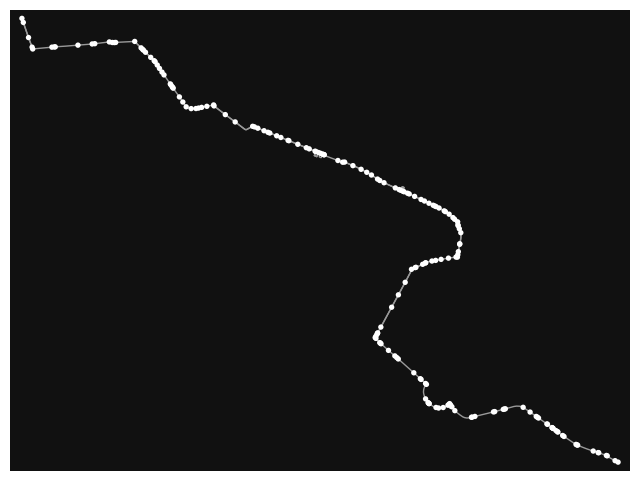

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
ox.plot_graph(subgraph)

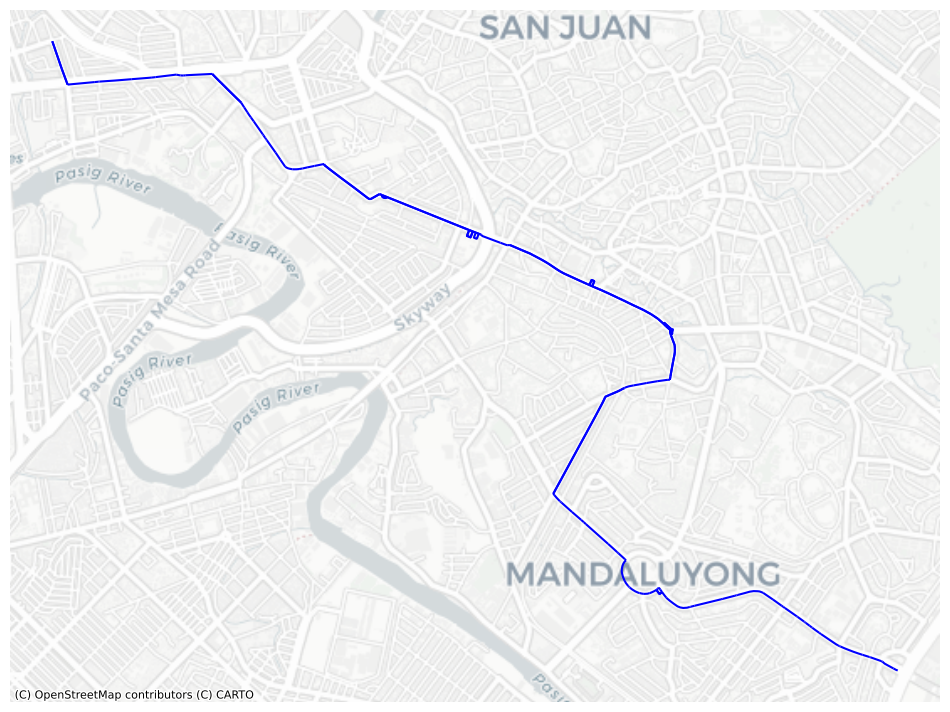

In [18]:
plot_graph(subgraph)

That looks good. However, relations in osmnx are not updated when nodes and edges are updated. Let's use a script to ensure that our route's nodes and edges exist in the osm api.

In [19]:
node_lst = list(get_nearest_nodes_from(graph_of_area, get_nodes()))

subgraph = generate_subgraph_from_node_lst(graph_of_area, node_lst)
# ox.plot_graph(subgraph)

# remove vertices with degree of 0
# subgraph.remove_nodes_from(list(nx.isolates(subgraph)))

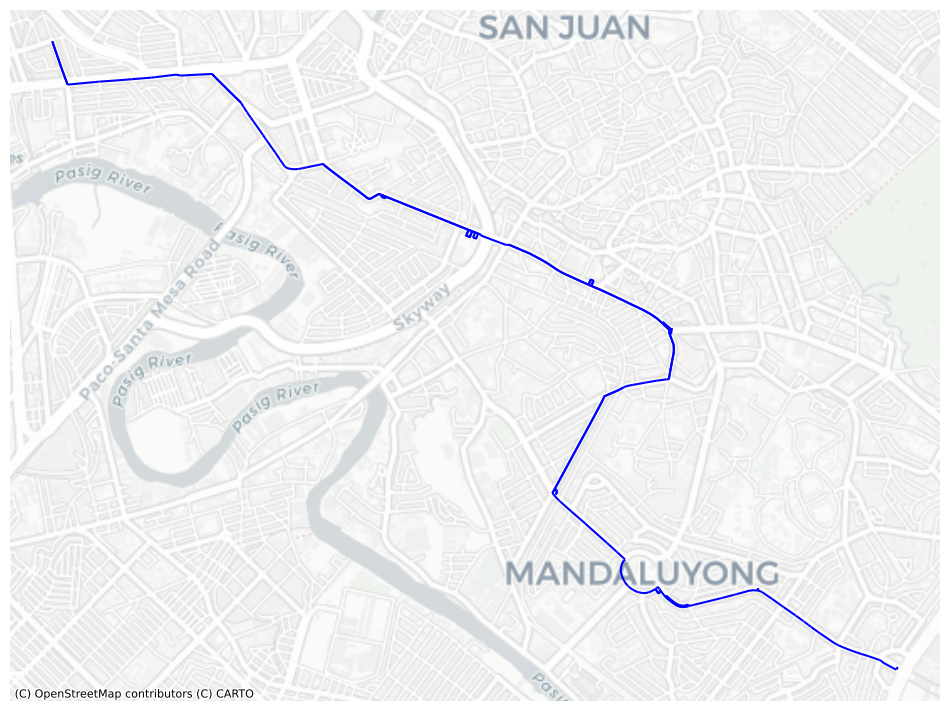

In [20]:
plot_graph(subgraph)

In [ ]:
def save_graph_as_geojson(graph, filename):
    # Convert nodes and edges to GeoDataFrames
    gdf_nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
    gdf_edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

    # Save to GeoJSON
    gdf_nodes.to_file(filename + '_nodes.geojson', driver='GeoJSON')
    gdf_edges.to_file(filename + '_edges.geojson', driver='GeoJSON')

# Save the subgraph as GeoJSON files
save_graph_as_geojson(subgraph, 'subgraph')

In [21]:
ox.io.save_graphml(subgraph, '../graphs/graphml/jeepneyroutes/T307-graph-original.graphml')

### Simulate Random Flooding and Rerouting Procedures

In [22]:
subgraph = ox.io.load_graphml('../graphs/graphml/jeepneyroutes/T307-graph-original.graphml')

In [23]:
def get_nearest_node_and_delete_it(node_id, graph, x, y):
    graph.remove_node(node_id)
    return get_nearest_node(graph, x, y)

def get_nearest_node(graph, x, y):
    nn, _ = tuple(nn_dist for nn_dist in ox.distance.nearest_nodes(graph.copy(), x, y, return_dist=True))
    return nn

def get_random_lst_of_nodes(graph, num_nodes_to_delete):
    random_nodes = []
    counter = 0
    while True:
        if counter == num_nodes_to_delete:
            break
        node = random.choice(list(graph.nodes))
        if len(list(graph.neighbors(node))) < 2:
            continue
        else:
            random_nodes.append(node)
            counter += 1
    return random_nodes

In [24]:
G = graph_of_area.copy()

In [25]:
G_sub = subgraph.copy()
num_nodes_to_delete = 5
deleted_nodes = get_random_lst_of_nodes(G_sub, num_nodes_to_delete)
print(deleted_nodes)

shortest_paths_between_closest_nodes = []
for node_id in deleted_nodes:
    try:
        if len(neighbors := list(G_sub.neighbors(node_id))) < 2:
            continue
    except nx.NetworkXError:
        continue
    else:
        G.remove_node(node_id)
        G_sub.remove_node(node_id)
        try:
            shortest_path = nx.shortest_path(G, source=neighbors[0], target=neighbors[1])
            print(shortest_path)
            shortest_paths_between_closest_nodes.append(shortest_path)
            existing_nodes = set(shortest_path).intersection(G_sub.nodes)
            g = nx.articulation_points(nx.MultiGraph(nx.compose(graph_of_area.subgraph(shortest_path), G_sub)))
            exclude = existing_nodes.intersection(g)
            print(exclude)
            if len(existing_nodes) > 2:
                G_sub.remove_nodes_from(list(existing_nodes - exclude))
        except nx.NetworkXNoPath:
            continue

[73002810, 7530780796, 261741171, 159119164, 266620670]
[311296381, 244119832, 244119830, 73002753, 10148668278, 73004266, 223783035, 73004268, 8318289768, 8318289776, 1335314423, 1335314424, 1335342361, 1722586580, 3397733579, 244128182, 255996419, 4417406126, 7557793930, 244128185]
{244128185, 311296381}
[2616905588, 610445242, 5971700427, 3736295061, 3736295066, 3736295069, 10722578921, 2616880233, 10722578920, 7530780800]
{10722578920, 2616880233, 610445242}
[262534704, 262535063, 266790614, 262535034, 262535036, 262535039, 6517417308, 6517417325, 6517417321, 6517417318]
{6517417321, 6517417325, 262534704, 6517417308, 262535039}
[5963272816, 159120711, 159120817, 1941072353, 1941072357]
{1941072357, 159120711}
[6507475889, 6507475886, 8670787799, 8670787796, 8578053767, 11613447650, 8655275221, 6640454751, 5429453837, 262535210, 262535063, 262534704, 261741416]
{11613447650, 8578053767, 6507475886, 262534704, 8670787796, 8670787799}


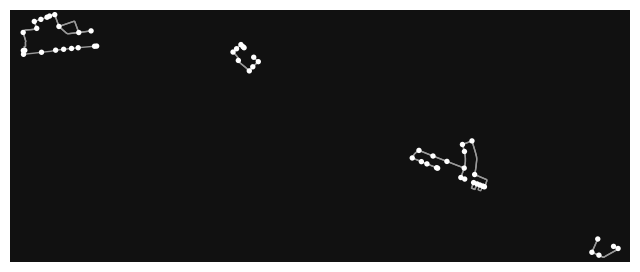

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
rerouted_sub_graph_lst = []
for path in shortest_paths_between_closest_nodes:
    rerouted_sub_graph_lst.append(graph_of_area.subgraph(path))
ox.plot_graph(nx.compose_all(rerouted_sub_graph_lst))

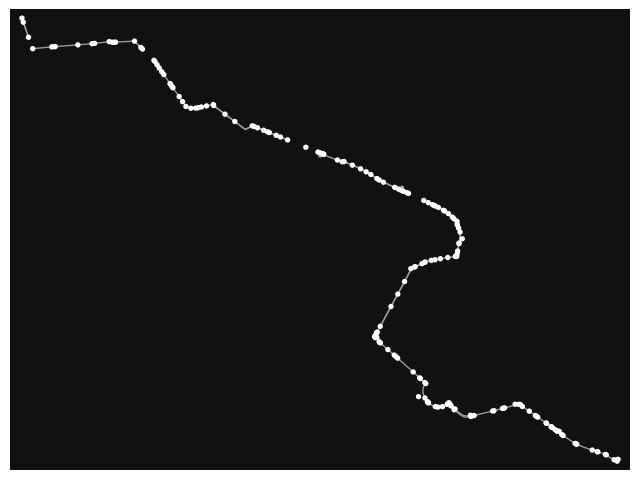

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
ox.plot_graph(G_sub)

In [28]:
rerouted_sub_graph = nx.compose(G_sub, nx.compose_all(rerouted_sub_graph_lst))
directed_rerouted_sub_graph = nx.MultiGraph(rerouted_sub_graph)

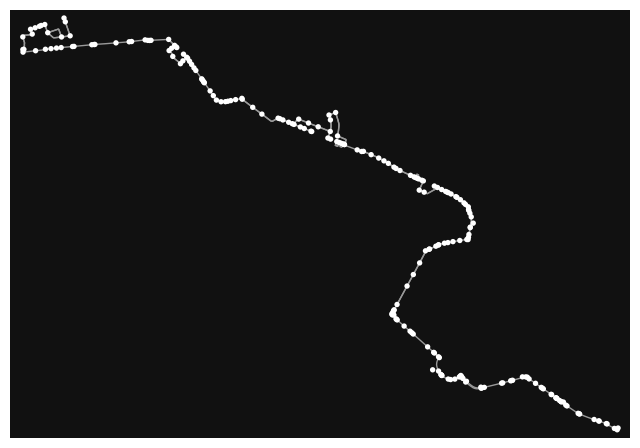

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [29]:
ox.plot_graph(rerouted_sub_graph)

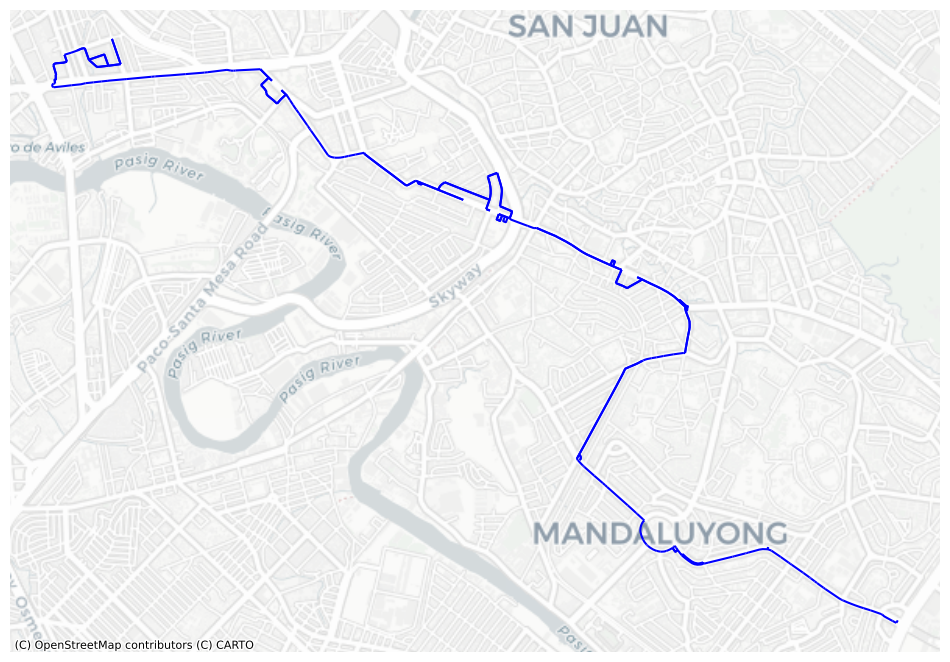

In [30]:
plot_graph(rerouted_sub_graph)

In [31]:
# Convert the rerouted subgraph to GeoDataFrames
gdf_edges_rerouted, gdf_nodes_rerouted = ox.graph_to_gdfs(rerouted_sub_graph)

# Save the edges and nodes to GeoDataFrames for use with Folium
gdf_edges_rerouted.to_file("rerouted_edges.geojson", driver='GeoJSON')
gdf_nodes_rerouted.to_file("rerouted_nodes.geojson", driver='GeoJSON')

# Conclusion

Written below was the discovery process that produced the desired effect above. These are not production codes.